## Creating a data set

In [1]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import math
%matplotlib inline
from tqdm import tqdm

In [113]:
def change_nan(value):   #function changing nan into 0 and 'tak' into 1
    for i in range(len(value)):
        try:
            if math.isnan(value[i]):
                value[i]=0
        except:
            if value[i]=='Tak':
                value[i]=1
            elif value[i]=='tak':
                value[i]=1  
        
    return value

def clean_guarantee(value):
    try:
        return int(value.split()[0])
    except:
        return value
    
def clean_instalment(x):
    if x=='0':
        return int(x)
    else:
        return int(''.join(x.split()[:-1]))
    
def change_price(x):
    try:
        cena = ''.join(x.split('PLN')[0].split())
        cena = ''.join(cena.split(',')[0].split())
        return int(cena)
    except:
        cena = 0
        return int(cena)
    
def change_date(x): #change string into datetime object
    try:
        if math.isnan(x):
            return 0
    except:
        pass
    if x=='0':
        return int(x)
    elif x==0:
        return x
    else:
        x=x.split()[0]
        return datetime.strptime(x, '%d/%m/%Y')
    
def guarantee_left(x): #how many months of guarantee left
    if x==0:
        return 0
    if x.year>datetime.now().year:
        time_left= (12-datetime.now().month)+(x.year-datetime.now().year-1)*12+x.month
        if time_left<0:
            return 0
        else:
            return time_left
    else:
        time_left=x.month-datetime.now().month
        if time_left<0:
            return 0
        else:
            return time_left

In [5]:
# getting info about one car
def get_info2(url):
    try:
        car_info={}
        soup=bs(requests.get(url).content)
        car_info['price']=soup.find(class_='offer-price__number').get_text(strip=True)
        parameters=soup.find(class_='parametersArea').find_all('li')
        for i in range(len(parameters)):
            try:
                key=parameters[i].find(class_='offer-params__label').get_text(strip=True)
                value=parameters[i].find(class_='offer-params__value').get_text(strip=True)
                car_info[key]=value
            except:
                continue
        
        #features=soup.find(class_='offer-features').find_all('li')
        #car_info['num of features']=len(features)
        
        return car_info
    except:
        pass

In [ ]:
df = pd.DataFrame()

In [63]:
#creating list of directories about cars
list_of_cars=[]
for k in tqdm([15, 16, 17, 18, 19, 20]): # k is year of production
    for j in tqdm(range(3)):      # j is a number of page
        soup=bs(requests.get('https://www.otomoto.pl/osobowe/mercedes-benz/glc-klasa/od-20{}'.format(k) + '/?search%5Bfilter_float_year%3Ato%5D=20{}'.format(k) + '&search%5Bfilter_enum_damaged%5D=0&search%5Border%5D=filter_float_price%3Aasc&search%5Bbrand_program_id%5D%5B0%5D=&search%5Bcountry%5D=&page={}'.format(j + 1)).content)
        offers_lst=soup.find(class_='offers list').find_all(class_='offer-item__title')
        for i in range(len(offers_lst)):
            link=offers_lst[i].a['href']
            list_of_cars.append(get_info2(link))

100%|██████████| 6/6 [04:03<00:00, 40.62s/it]


In [65]:
#removing None objects in list_of_cars
length=len(list_of_cars)
for i in range(length):
    if list_of_cars[i]==None:
        list_of_cars.remove(list_of_cars[i])
        length=len(list_of_cars)

In [66]:
#creating a data frame
df = pd.concat((df, pd.DataFrame(list_of_cars)), axis = 0)
df = df.reset_index(drop = True)

In [ ]:
df['price'] = df['price'].apply(change_price)
df.drop(df[df['price'] == 0].index, axis =0, inplace = True)

In [89]:
df.to_csv('samochody')

## analiza samochodow do kupienia

In [119]:
df = pd.read_csv('samochody')
df.drop(df.columns[0], axis = 1, inplace = True)

In [87]:
columns = df.columns[:15]
columns

Index(['price', 'Oferta od', 'Kategoria', 'Marka pojazdu', 'Model pojazdu',
       'Generacja', 'Rok produkcji', 'Przebieg', 'Pojemność skokowa',
       'Rodzaj paliwa', 'Moc', 'Skrzynia biegów', 'Napęd',
       'Filtr cząstek stałych', 'Typ'],
      dtype='object')

In [121]:
df['price'] = df['price'].apply(change_price)
df.drop(df[df['price'] == 0].index, axis = 0, inplace = True)

In [130]:
df = df[columns]

In [209]:
df.head()

,price,Oferta od,Kategoria,Marka pojazdu,Model pojazdu,Generacja,Rok produkcji,Przebieg,Pojemność skokowa,Rodzaj paliwa,Moc,Skrzynia biegów,Napęd,Filtr cząstek stałych,Typ
0,63999,Firmy,Osobowe,Audi,A6,C7 (2011-2018),2015,229 000 km,1 968 cm3,Diesel,190 KM,Manualna,Na przednie koła,Tak,Kombi
1,64900,Firmy,Osobowe,Audi,A6,C7 (2011-2018),2015,44 000 km,1 984 cm3,Benzyna,252 KM,Automatyczna,4x4 (stały),NaN,Sedan
2,66900,Firmy,Osobowe,Audi,A6,C7 (2011-2018),2015,271 000 km,2 000 cm3,Diesel,190 KM,Automatyczna,Na przednie koła,NaN,Kombi
3,68000,Osoby prywatnej,Osobowe,Audi,A6,C7 (2011-2018),2015,139 521 km,2 000 cm3,Diesel,190 KM,Manualna,Na przednie koła,Tak,Kombi
4,68900,Firmy,Osobowe,Audi,A6,C7 (2011-2018),2015,161 000 km,1 968 cm3,Diesel,150 KM,Manualna,Na przednie koła,NaN,Kombi


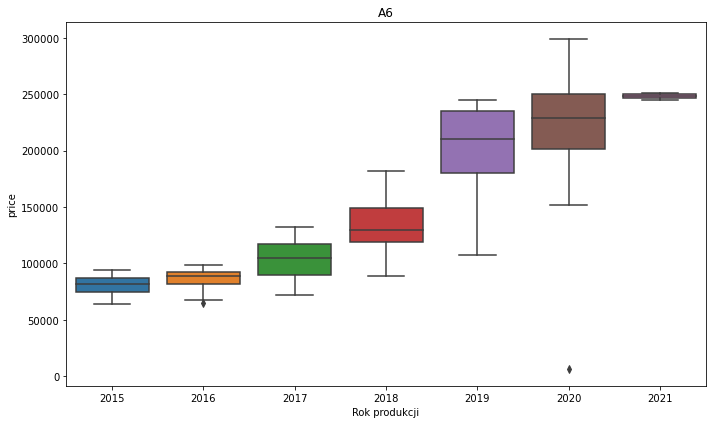

In [199]:
fig, axes = plt.subplots(figsize = (10, 6))
    
x = np.arange(2015, 2021)
df1 = df[df['Model pojazdu'] == 'A6']
sns.boxplot(x = 'Rok produkcji', y = 'price', data = df1)
axes.set_title('A6')
plt.tight_layout()

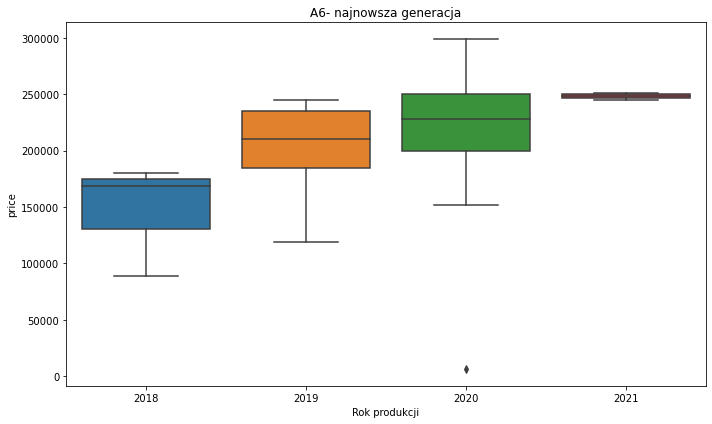

In [212]:
fig, axes = plt.subplots(figsize = (10, 6))
    
x = np.arange(2015, 2021)
df1 = df[(df['Model pojazdu'] == 'A6') & (df['Generacja'] == 'C8 (2018-)')]
sns.boxplot(x = 'Rok produkcji', y = 'price', data = df1)
axes.set_title('A6- najnowsza generacja')
plt.tight_layout()

In [223]:
np.percentile(df[(df['Model pojazdu'] == 'A6') & (df['Generacja'] == 'C8 (2018-)') & (df['Rok produkcji'] == 2018)]['price'], 30)

135268.0

In [226]:
len(df[(df['Model pojazdu'] == 'A6') & (df['Rok produkcji'] == 2018)])

96

In [228]:
len((df[(df['Model pojazdu'] == 'A6') & (df['Generacja'] == 'C8 (2018-)') & (df['Rok produkcji'] == 2018)]))

15

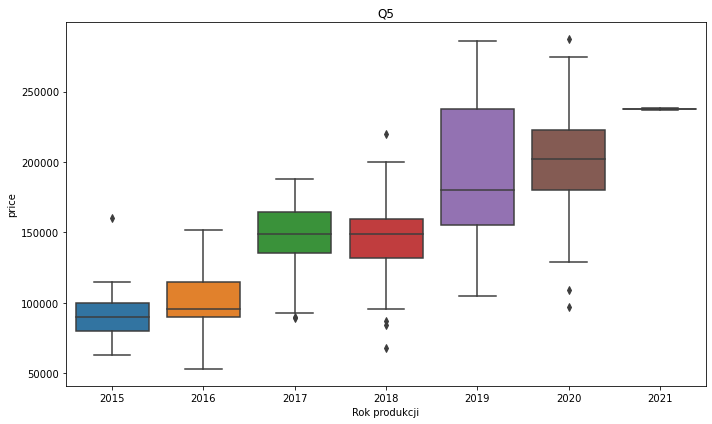

In [200]:
fig, axes = plt.subplots(figsize = (10, 6))
    
x = np.arange(2015, 2021)
df1 = df[df['Model pojazdu'] == 'Q5']
sns.boxplot(x = 'Rok produkcji', y = 'price', data = df1)
axes.set_title('Q5')
plt.tight_layout()

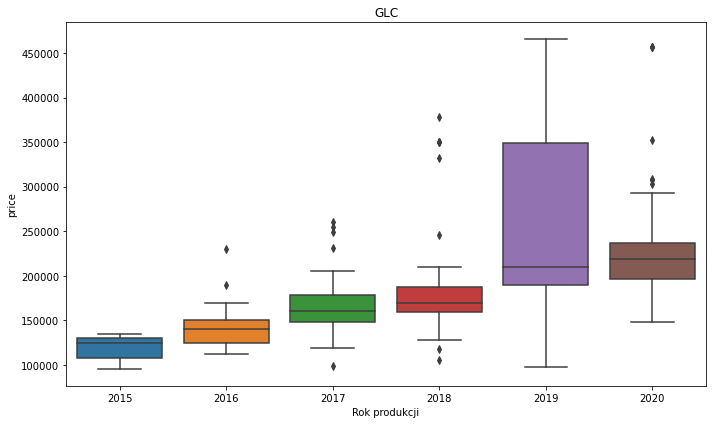

In [230]:
fig, axes = plt.subplots(figsize = (10, 6))
    
x = np.arange(2015, 2021)
df1 = df[df['Model pojazdu'] == 'GLC']
sns.boxplot(x = 'Rok produkcji', y = 'price', data = df1)
axes.set_title('GLC')
plt.tight_layout()

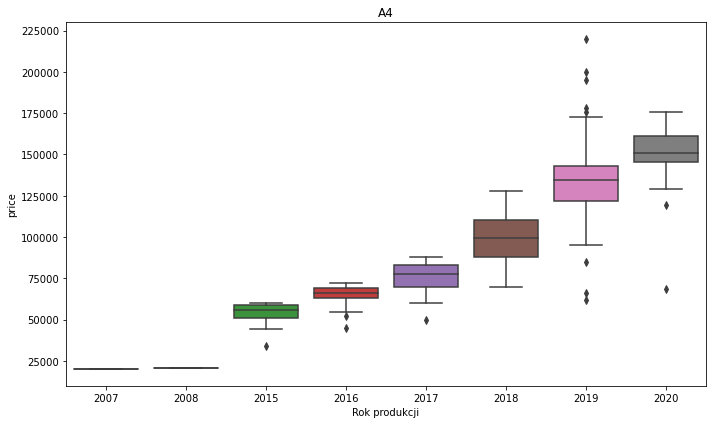

In [229]:
fig, axes = plt.subplots(figsize = (10, 6))
    
x = np.arange(2015, 2021)
df1 = df[df['Model pojazdu'] == 'A4']
sns.boxplot(x = 'Rok produkcji', y = 'price', data = df1)
axes.set_title('A4')
plt.tight_layout()

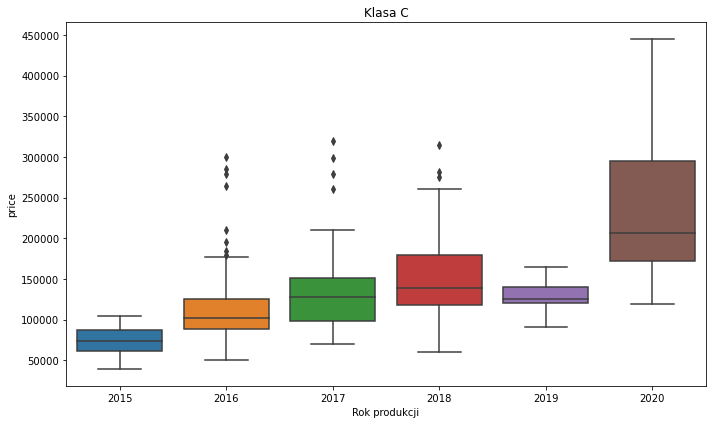

In [201]:
fig, axes = plt.subplots(figsize = (10, 6))
    
x = np.arange(2015, 2021)
df1 = df[df['Model pojazdu'] == 'Klasa C']
sns.boxplot(x = 'Rok produkcji', y = 'price', data = df1)
axes.set_title('Klasa C')
plt.tight_layout()

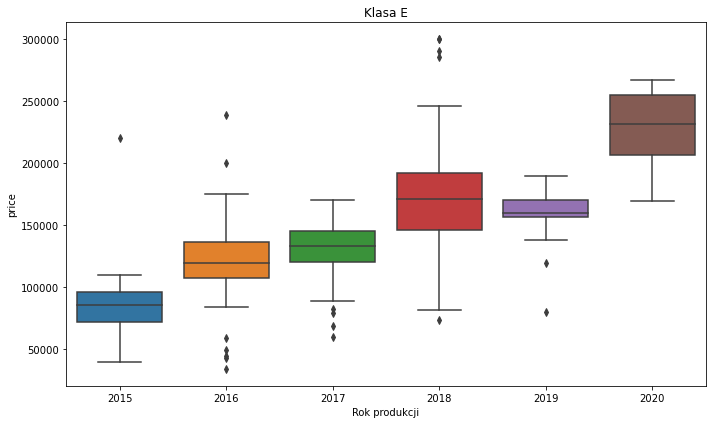

In [203]:
fig, axes = plt.subplots(figsize = (10, 6))
    
x = np.arange(2015, 2021)
df1 = df[df['Model pojazdu'] == 'Klasa E']
sns.boxplot(x = 'Rok produkcji', y = 'price', data = df1)
axes.set_title('Klasa E')
plt.tight_layout()

In [208]:
len(df[(df['Model pojazdu'] == 'Klasa C') & (df['Rok produkcji'] == 2020)])

44

We will create seperate data frame for cars which have steering wheel on the right or which are antique.

In [ ]:
#cars that has steering wheel on the right or which are antique
df1=df[(df['Kierownica po prawej (Anglik)']=='Tak')|(df['Zarejestrowany jako zabytek'].isnull()!=True)]

In [ ]:
df1[df1['Zarejestrowany jako zabytek'].isnull()!=True][['Marka pojazdu','Model pojazdu','Rok produkcji','Zarejestrowany jako zabytek']]

This cars doesn't seem to be an antique so we will remove them from our data frame. We will also remove cars with steering wheel on the right and cars with unpaid credit because there are just a few cars like that and they may not fit into our model.

In [ ]:
#removing cars with steering wheel on the right or which are antique
df.drop(df[df['Kierownica po prawej (Anglik)']=='Tak'].index,inplace=True)
df.drop(df[df['Liczba pozostałych rat'].isnull()!=True].index,inplace=True)
df.drop(df[df['Zarejestrowany jako zabytek'].isnull()!=True].index,inplace=True)
df.drop('Kolor',axis=1,inplace=True)

In [ ]:
df=df.reset_index(drop=True)

Now we will deal with missing values.

In [ ]:
sns.heatmap(df[df.columns[20:40]].isnull())

We will remove columns which are unnecessary or which have too much nan values.

In [ ]:
#removin columns which are unnecessary or which have too much nan values
df.drop(['Emisja CO2','Faktura VAT','Generacja','Homologacja ciężarowa','Kierownica po prawej (Anglik)',
        'Kod Silnika','Leasing','Liczba pozostałych rat','Miesięczna rata','Możliwość finansowania',
        'Numer rejestracyjny pojazdu','Opłata początkowa','Pierwsza rejestracja','VAT marża','Wartość wykupu','Wersja',
        'Zarejestrowany jako zabytek','lub do (przebieg km)','Liczba drzwi','Liczba miejsc','Napęd'],axis=1,inplace=True)

Missing values in country of origin column we will set as Polska because I think that is the most probably value and this might be important for our model.

In [ ]:
#changing NaN values in 'Kraj pochodzenia' into Polska
for i in range(df['price'].count()):
    try:
        if math.isnan(df['Kraj pochodzenia'][i]):
            df['Kraj pochodzenia'][i]='Polska'
    except:
        continue

We will remove cars with missing values in columns power, capacity of an engine and gear box.

In [ ]:
#removing rows with missing values
df.drop(df[df['Moc'].isnull()==True].index,inplace=True)
df.drop(df[df['Pojemność skokowa'].isnull()==True].index,inplace=True)
df.drop(df[df['Skrzynia biegów'].isnull()==True].index,inplace=True)
df.drop(df[df['price']=='5 600EUR'].index,inplace=True)

In the rest of columns when we have missing value it means that a given car doesn't have a feature which this column represents, so we will fill this fields with 0, and if a given car does have some feature we will set 1.

In [ ]:
#changing nan values into 0 and 'Tak' into 1
df=df.apply(change_nan)

In [ ]:
df['Stan'].unique()

In [ ]:
df['Kategoria'].unique()

We will remove unnecessary columns category and condition, because every car has the same value in this columns.

In [ ]:
#removing unnecessary clumns
df.drop('Stan',axis=1,inplace=True)
df.drop('Kategoria',axis=1,inplace=True)

In [ ]:
df=df.reset_index(drop=True)

Now we will change format of some columns, from string into float or date.time object.

In [ ]:
#changing format of some columns
df['Moc']=df['Moc'].apply(clean_guarantee)
df['Pojemność skokowa']=df['Pojemność skokowa'].apply(clean_instalment)
df['Przebieg']=df['Przebieg'].apply(clean_instalment)
df['price']=df['price'].apply(change_price)
df['Okres gwarancji producenta']=df['Okres gwarancji producenta'].apply(change_date)
df['Gwarancja dealerska (w cenie)']=df['Gwarancja dealerska (w cenie)'].apply(clean_guarantee)

We will fix values in Metalik column. Instead of 'metallic' there shoud be 1.

In [ ]:
#fixing values in 'Metalik' column
for i in range(df['price'].count()):
    if df[df.columns[7]][i]=='metallic':
        df[df.columns[7]][i]=1

We will create a new column informing about how much guarantee has left.

In [ ]:
for i in range(df['price'].count()):
    if df['Gwarancja dealerska (w cenie)'][i]!=0:
        df['guarantee left'][i]=df['Gwarancja dealerska (w cenie)'][i]
    else:
        df['guarantee left'][i]=guarantee_left(df['Okres gwarancji producenta'][i])

In [ ]:
df.columns

Now we will change some columns into categorical.

In [ ]:
#Changing some columns into categorical

df=pd.concat([df,pd.get_dummies(df['Marka pojazdu'])],axis=1)
#df1.drop('Marka pojazdu',axis=1,inplace=True)

df=pd.concat([df,pd.get_dummies(df['Model pojazdu'])],axis=1)
#df1.drop('Model pojazdu',axis=1,inplace=True)

df=pd.concat([df,pd.get_dummies(df['Oferta od'])],axis=1)

df=pd.concat([df,pd.get_dummies(df['Rodzaj paliwa'])],axis=1)

df=pd.concat([df,pd.get_dummies(df['Skrzynia biegów'])],axis=1)

df=pd.concat([df,pd.get_dummies(df['Typ'])],axis=1)

df=pd.concat([df,pd.get_dummies(df['Kraj pochodzenia'])],axis=1)

In [ ]:
df=df.rename(columns={'Model pojazdu':'model','Marka pojazdu':'brand','Moc':'power','Rok produkcji':'year of production',
            'Pojemność skokowa':'capacity of an engine','Przebieg':'mileage'})

In [ ]:
df.to_csv('otomoto clean 3')

## Exploratory data analysis

In [ ]:
df=pd.read_csv('otomoto clean 3')
df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
important_params=['model','brand','power','year of production','capacity of an engine','mileage','price']

Let's see how a distubution of a price, a mileage, a year of production and a power looks like.

In [ ]:
plt.hist(df['price'],bins=20)

In [ ]:
pd.DataFrame(df['mileage'].unique()).sort_values(by=0)

In [ ]:
plt.hist(df['mileage'],bins=20)

In [ ]:
plt.hist(df['year of production'],bins=20)

In [ ]:
plt.hist(df['power'],bins=20)

## mean price for brands

In [ ]:
fig,axes=plt.subplots(figsize=(12,6))
sns.barplot(y='brand',x='price',data=df)

Let's sort brands by a mean price. 

In [ ]:
pd.DataFrame(df.groupby('brand').mean()['price']).sort_values(by='price',ascending=False)

## most popular brands

In [ ]:
pd.DataFrame(df.groupby('brand').count()['price']).rename(columns={'price':'amount of offers'}).sort_values(by='amount of offers',ascending=False)

## cars with biggest power

In [ ]:
df1[df1['mileage']<=200000][important_params].sort_values(by='power',ascending=False)

## distribution of a price for cars with different mileage

In [ ]:
bins=[0,50000,100000,150000,200000,250000,300000,350000,float('inf')]
df['mileage category']=pd.cut(df['mileage'],bins,labels=[1,2,3,4,5,6,7,8])

In [ ]:
sns.boxplot(x='mileage category',y='price',data=df)

A mileage category 1 means mileage between 0 and 50000, a mileage category 2 means mileage between 50000 and 100000, a mileage category 3 means mileage between 100000 and 150000 etc.

## distribution of a price for cars with different power

In [ ]:
bins=[0,100,150,200,250]
df['power category']=pd.cut(df['power'],bins,labels=[1,2,3,4])

In [ ]:
sns.boxplot(x='power category',y='price', data=df)

A power category 1 means a power between 0 and 100, a power category 2 means a power between 100 and 150, a power category 3 means a power between 150 and 200, etc.

## distribution of a price for cars produced in different years

In [ ]:
bins=[float('-inf'),2000,2003,2006,2009,2012,2016,2018]
df2=pd.DataFrame(pd.cut(df['year of production'],bins,labels=[1,2,3,4,5,6,7])).rename(columns={'year of production':'year category'})
df2

In [ ]:
sns.boxplot(x='year category',y='price',data=pd.concat([df,df2],axis=1))

A year category 1 means a year of production before 2000, a year category 2 means a year of production between 2000 and 2003, a year category 3 means a year of production between 2004 and 2007, a year category 4 means a year of production between 2008 and 2011, etc.

## distribution of a price for cars with different power and produced in different years

In [ ]:
sns.FacetGrid(pd.concat([df,df2],axis=1),row='power category',aspect=2).map(sns.boxplot,'year category','price')

In [ ]:
sns.heatmap(df[['power','year of production','capacity of an engine','mileage','price']].corr(),annot=True)

## model building

In [6]:
df=pd.read_csv('otomoto clean 3')

In [7]:
df1=df.drop(['brand','model','Oferta od','Rodzaj paliwa','Skrzynia biegów','Typ',
              'Okres gwarancji producenta','Kraj pochodzenia'],axis=1)

I have checked a different models and the best one was the Linear Regression. We will calculate root mean squared error in order to evaluate how good our model is performing.

In [ ]:
from sklearn.model_selection import train_test_split
x=df1.drop('price',axis=1)
y=df1['price']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model=LinearRegression()
model.fit(x_train,y_train)
pred=model.predict(x_test)
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test,pred))))

## model 2

In this model we will remove outliers.

In [ ]:
df1['mileage'].sort_values()

In [ ]:
df1=df1[df1['mileage']<=519332]

In [ ]:
plt.hist(df1['mileage'])

In [ ]:
plt.hist(df1['power'])

In [ ]:
plt.hist(df1[df1['power']>250]['power'])

In [ ]:
plt.hist(df1[df1['power']<70]['power'])

In [ ]:
plt.hist(df1[(df1['power']>=56)&(df1['power']<=306)]['power'])

In [ ]:
df1=df1[(df1['power']>=56)&(df1['power']<=306)]

In [ ]:
plt.hist(df1['year of production'],bins=20)

In [ ]:
df1[df1['year of production']<=2002]['year of production'].value_counts()

In [ ]:
df1=df1[df1['year of production']>=2000]

In [ ]:
from sklearn.model_selection import train_test_split
x=df1.drop('price',axis=1)
y=df1['price']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model=LinearRegression()
model.fit(x_train,y_train)
pred=model.predict(x_test)
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test,pred))))

Let's see how a distribution of an error (error = |real price - predicted price|) looks like.

In [ ]:
error=[]
for i in range(len(pred)):
    x=pred[i]
    y=y_test.values[i]
    error.append(abs(y-x))

In [ ]:
sns.boxplot(pd.DataFrame(error))

From this graph we can see that in 75% of cases the error was smaller than 5000 and in almost all cases the error was smaller 10000. 

Now we will define error as a ratio of a difference of prices to a real price (error = |real price - predicted price| / real price)

In [ ]:
error=[]
for i in range(len(pred)):
    x=pred[i]
    y=y_test.values[i]
    error.append(abs(y-x)/y)

In [ ]:
sns.boxplot(pd.DataFrame(error))

From this graph we can see that in 75% of cases the error was smaller than 20% of a real price and in almost all cases it was smaller than 40% of a real price.